# Previsão de renda

## Etapa 1 CRISP - DM: Entendimento do negócio

Esse projeto tem como objetivo criar um modelo de regressão linear para prever a renda dos clientes. 

Serão criados dois modelos:

    - um modelo utilizando Árvores de Regressão com a biblioteca sklearn
    - um modelo utilizando Regressão Linear com a biblioteca statsmodels.

Os algoritmos serão treinados a partir dos dados históricos do arquivo "previsao-renda.csv".


## Etapa 2 Crisp-DM: Entendimento dos dados

Foram fornecidas 14 variáveis mais a variável resposta ('renda', em negrito na tabela). O significado de cada uma dessas variáveis se encontra na tabela.

Os dados estão dispostos em uma tabela com uma linha para cada cliente, e uma coluna para cada variável armazenando as características desses clientes. 

O dicionário de dados (explicação dessas variáveis) encontra-se logo abaixo.


### Dicionário de dados


| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data de referência                                 | Datetime |
| id_cliente              |  ID do cliente                                      | Inteiro |
| sexo                    |  M = 'Masculino'; F = 'Feminino'                    | Binário |
| posse_de_veiculo        |  Y = 'possui'; N = 'não possui'                     | Binário |
| posse_de_imovel         |  Y = 'possui'; N = 'não possui'                     | Binário |
| qtd_filhos              |  Quantidade de filhos                               | Inteiro |
| tipo_renda              |  Tipo de renda (ex: assaláriado, autônomo, etc.)    | Texto |
| educacao                |  Nível de educação (ex: secundário, superior etc.)  | Texto |
| estado_civil            |  Estado civil (ex: solteiro, casado, etc.)          | Texto |
| tipo_residencia         |  Tipo de residência (ex: casa/apartamento, etc.)    | Texto |
| idade                   |  Idade em anos                                      | Inteiro |
| tempo_emprego           |  Tempo de emprego em anos                           | Inteiro |
| qt_pessoas_residencia   |  Quantidade de pessoas na residência                | Inteiro |
| **renda**               |  **Renda mensal**                                   | **Decimal**|





#### Carregando os pacotes

In [1]:
#!pip install pandas-profiling

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as stm

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport


%matplotlib inline

C:\Users\davi_\AppData\Local\Temp\ipykernel_1764\2077455430.py:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


#### Carregando os dados

Leitura do arquivo CSV:

In [3]:
df = pd.read_csv('./input/previsao_de_renda.csv')

# Tirar variaveis que não serão utilizadas
df.drop(['Unnamed: 0', 'index', 'mau'], axis=1, inplace=True)

print(f"Número de linhas/colunas = {df.shape}")

df.head(3)

Número de linhas/colunas = (15000, 13)


,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,F,False,True,1,Assalariado,Secundário,Casado,Casa,36,3.575342,3.0,3369.24
1,2015-01-01,M,True,True,0,Empresário,Secundário,Casado,Casa,42,0.860274,2.0,6096.14
2,2015-01-01,M,True,True,2,Assalariado,Superior completo,Casado,Casa,31,8.065753,4.0,5658.98


#### Entendimento dos dados - Univariada

- Para facilitar essa analise, será gerada uma página html com dados de cada variável através do ProfileReport, mas também serão analisadas uma a uma através do Python.

###### Geração do ProfileReport:

In [4]:
# Criação do profile
prof = ProfileReport(df, explorative=True, minimal=True)

# Salvar em html
prof.to_file('./output/renda_analisys.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Pode-se conferir que a base não possui valores nulos/faltantes para nenhuma das colunas, porém o tipo de algumas variáveis precisam ser ajustados.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data_ref               15000 non-null  object 
 1   sexo                   15000 non-null  object 
 2   posse_de_veiculo       15000 non-null  bool   
 3   posse_de_imovel        15000 non-null  bool   
 4   qtd_filhos             15000 non-null  int64  
 5   tipo_renda             15000 non-null  object 
 6   educacao               15000 non-null  object 
 7   estado_civil           15000 non-null  object 
 8   tipo_residencia        15000 non-null  object 
 9   idade                  15000 non-null  int64  
 10  tempo_emprego          12466 non-null  float64
 11  qt_pessoas_residencia  15000 non-null  float64
 12  renda                  15000 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(6)
memory usage: 1.3+ MB


###### Variáveis binárias:

Variáveis estão bem distribuídas, aparentemente a única coisa a tratar é trocar os domínios para 0 e 1.

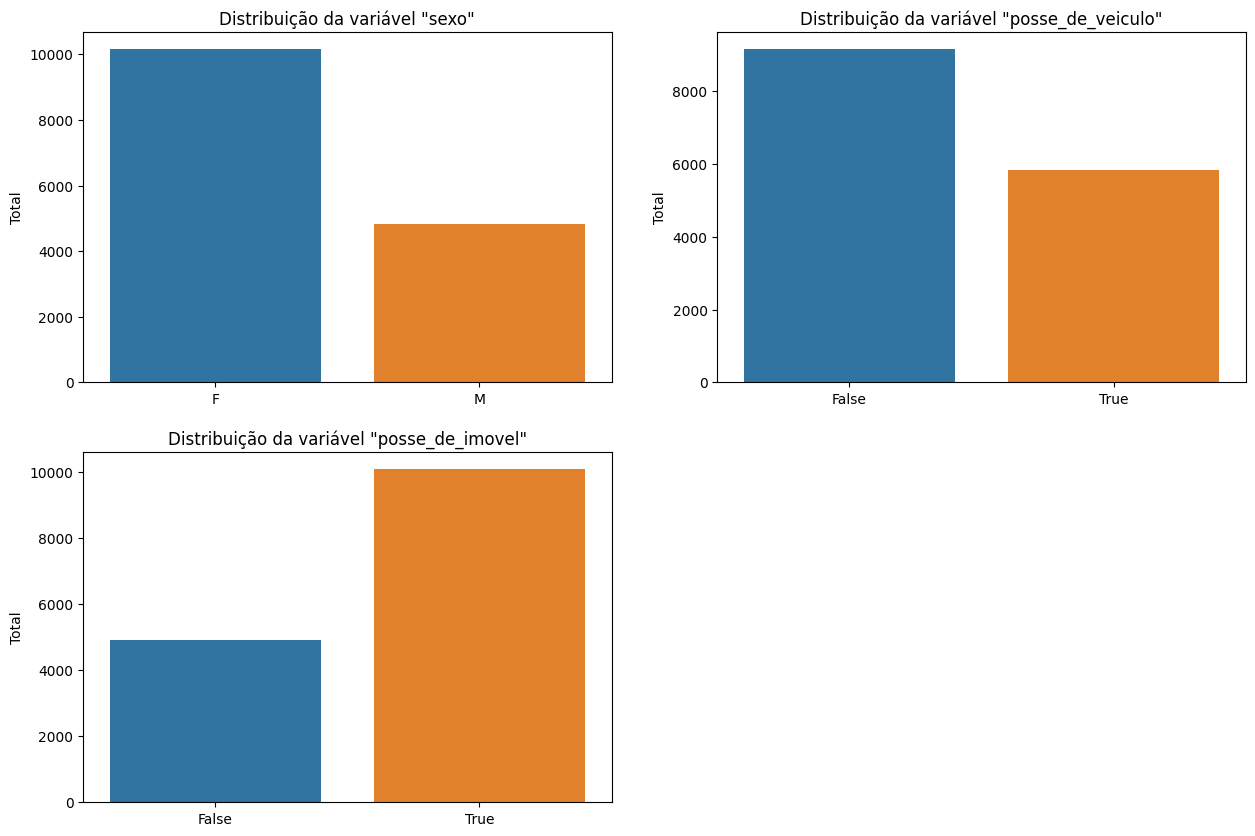

In [6]:
figura, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))

sns.countplot(data = df, x = 'sexo', ax = ax1)
sns.countplot(data = df, x = 'posse_de_veiculo', ax = ax2)
sns.countplot(data = df, x = 'posse_de_imovel', ax = ax3)

ax1.set_title('Distribuição da variável "sexo"')
ax2.set_title('Distribuição da variável "posse_de_veiculo"')
ax3.set_title('Distribuição da variável "posse_de_imovel"')

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

ax1.set_ylabel('Total')
ax2.set_ylabel('Total')
ax3.set_ylabel('Total')

ax4.remove()

###### Variáveis numéricas

* **idade:** apresenta uma boa distribuição e não precisará ser tratada.
* **tempo_emprego:** possui outliers superiores que podem afetar o modelo.
* **qtd_filhos:** possui outliers que deverãos ser tratados.
* **qt_pessoas_residencia:** possui outliers que deverãos ser tratados.

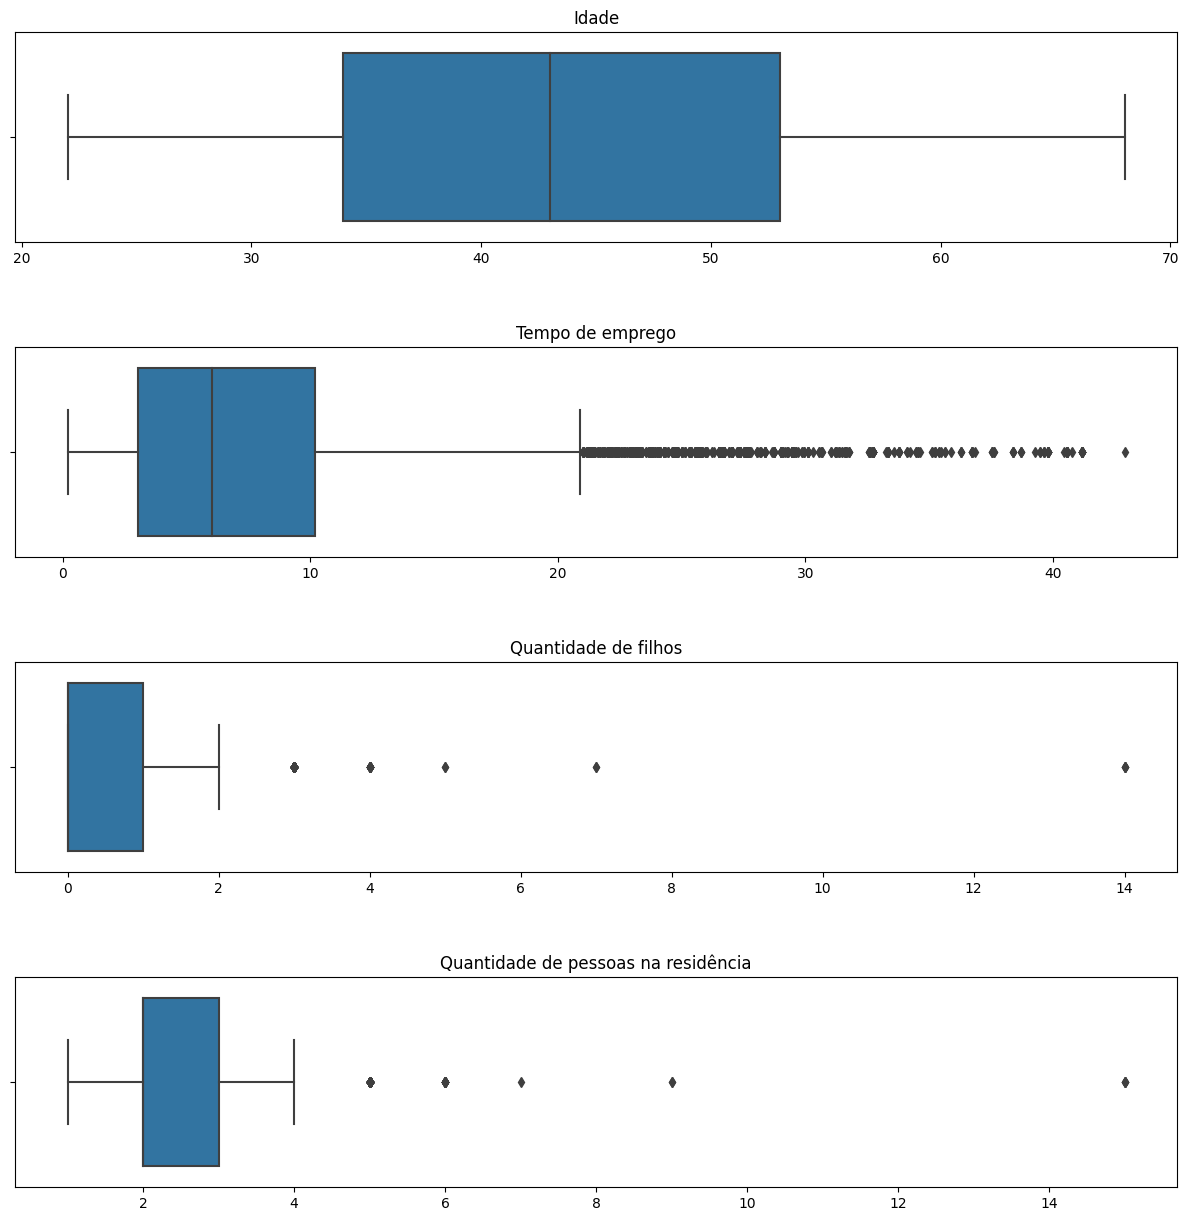

,count,mean,std,min,25%,50%,75%,max
idade,15000.0,43.841400,11.229170,22.000000,34.000000,43.000000,53.000000,68.000000
tempo_emprego,12466.0,7.750462,6.780216,0.191781,3.016438,6.016438,10.183562,42.906849
qtd_filhos,15000.0,0.437267,0.760594,0.000000,0.000000,0.000000,1.000000,14.000000
qt_pessoas_residencia,15000.0,2.219067,0.922352,1.000000,2.000000,2.000000,3.000000,15.000000


In [7]:
figura, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 15))

sns.boxplot(data = df, x = 'idade', ax = ax1)
sns.boxplot(data = df, x = 'tempo_emprego', ax = ax2)
sns.boxplot(data = df, x = 'qtd_filhos', ax = ax3)
sns.boxplot(data = df, x = 'qt_pessoas_residencia', ax = ax4)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')

ax1.set_title('Idade')
ax2.set_title('Tempo de emprego')
ax3.set_title('Quantidade de filhos')
ax4.set_title('Quantidade de pessoas na residência')

figura.subplots_adjust(hspace=0.5, wspace=0.5)

plt.show()

df[ ['idade', 'tempo_emprego', 'qtd_filhos', 'qt_pessoas_residencia'] ].describe().transpose()

###### Variáveis categóricas

* **tipo_renda**: categoria "bolsista" com uma frequencia extremamente baixa.

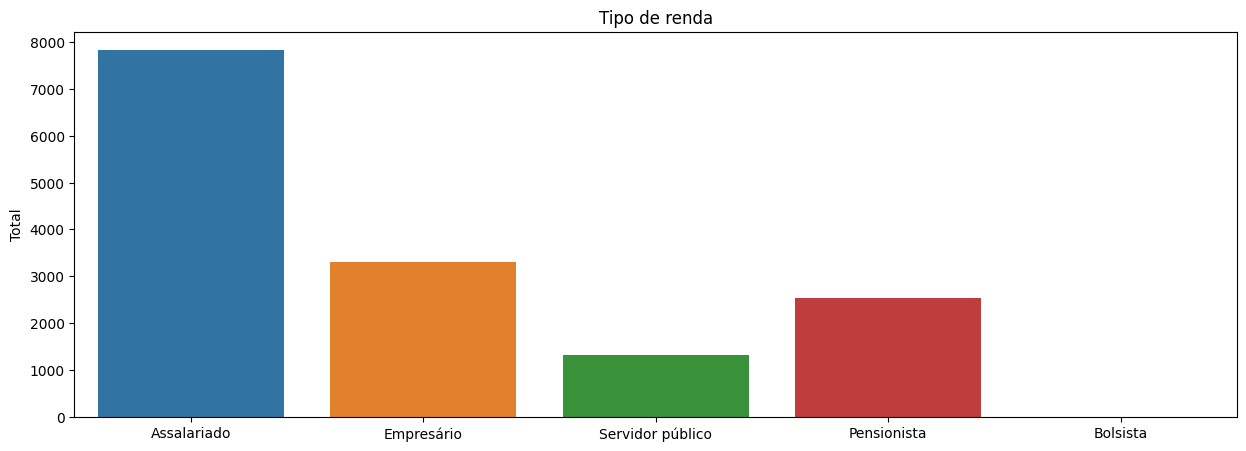

Assalariado         7826
Empresário          3311
Pensionista         2543
Servidor público    1316
Bolsista               4
Name: tipo_renda, dtype: int64

In [8]:
figura = plt.figure(figsize=(15,5))

ax = sns.countplot(data = df, x = 'tipo_renda')
ax.set_title("Tipo de renda")
ax.set_xlabel("")
ax.set_ylabel("Total")

plt.show()

df['tipo_renda'].value_counts()

- **educacao**: categoria "Pós graduação" com uma frequencia extremamente baixa.

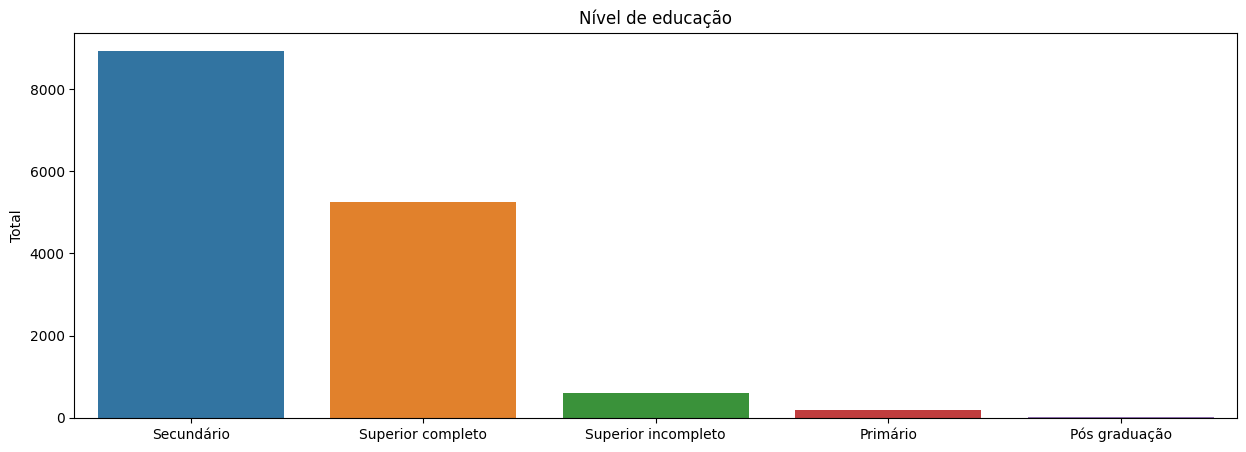

Secundário             8927
Superior completo      5262
Superior incompleto     599
Primário                193
Pós graduação            19
Name: educacao, dtype: int64

In [9]:
figura = plt.figure(figsize=(15,5))

ax = sns.countplot(data = df, x = 'educacao')
ax.set_title("Nível de educação")
ax.set_xlabel("")
ax.set_ylabel("Total")

plt.show()

df['educacao'].value_counts()

- **estado_civil**: dados aparentemente bem distribuídos, com a predominancia em "Casado"

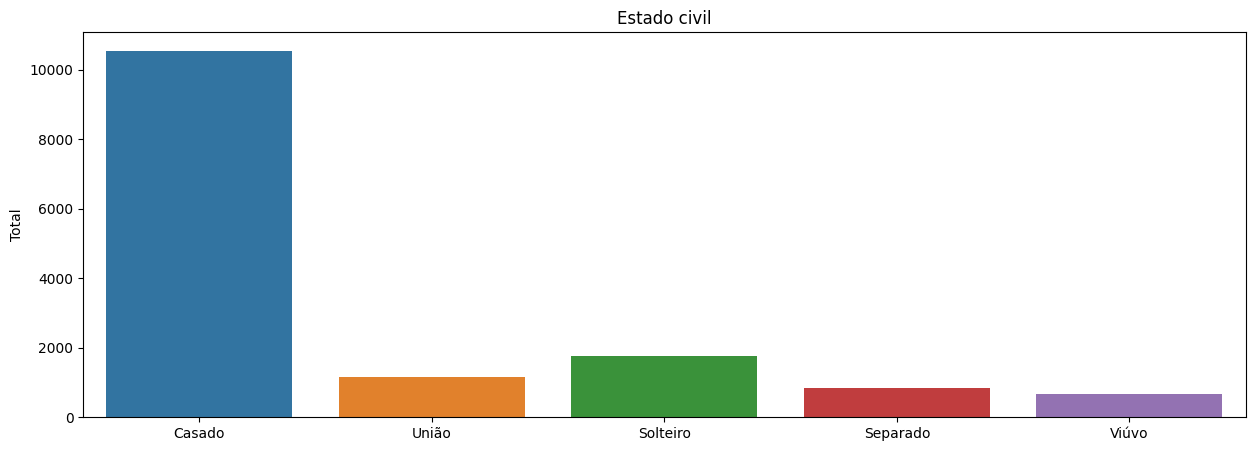

Casado      10550
Solteiro     1767
União        1168
Separado      838
Viúvo         677
Name: estado_civil, dtype: int64

In [10]:
figura = plt.figure(figsize=(15,5))

ax = sns.countplot(data = df, x = 'estado_civil')
ax.set_title("Estado civil")
ax.set_xlabel("")
ax.set_ylabel("Total")

plt.show()

df['estado_civil'].value_counts()

- **tipo_residencia**: categoria "Comunitário" com uma baixa frequência.

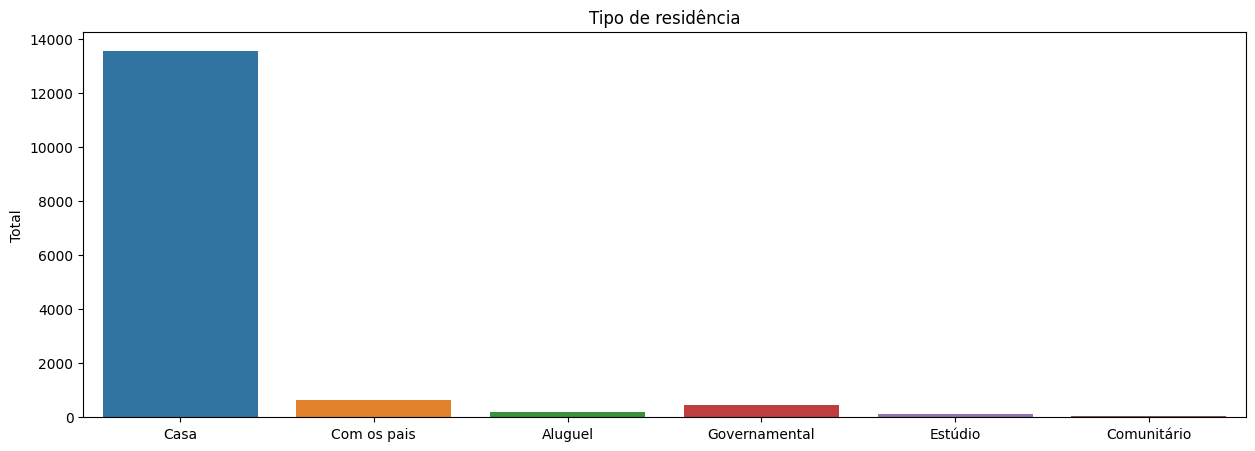

Casa             13566
Com os pais        637
Governamental      443
Aluguel            184
Estúdio            107
Comunitário         63
Name: tipo_residencia, dtype: int64

In [11]:
figura = plt.figure(figsize=(15,5))

ax = sns.countplot(data = df, x = 'tipo_residencia')
ax.set_title("Tipo de residência")
ax.set_xlabel("")
ax.set_ylabel("Total")

plt.show()

df['tipo_residencia'].value_counts()

### Entendimento dos dados - Bivariadas




<span style="color:red">ESCREVER AQUI</span>


## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



<span style="color:red">ESCREVER AQUI</span>


## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


<span style="color:red">ESCREVER AQUI</span>


### Rodando o modelo


<span style="color:red">ESCREVER AQUI</span>


## Etapa 5 Crisp-DM: Avaliação dos resultados


<span style="color:red">ESCREVER AQUI</span>


## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.